In [1]:
%run common.ipynb

In [2]:
# read callsets
callset_a = zarr.open(HAPS_ZARR, mode='r')
callset_x = zarr.open(HAPS_X_ZARR, mode='r')

In [3]:
callset_a['2L'].tree()

2L
 ├── calldata
 │   └── genotype (8906423, 1164, 2) int8
 ├── samples (1164,) |S8
 └── variants
     ├── ALT (8906423,) |S1
     ├── ID (8906423,) |S8
     ├── POS (8906423,) int32
     └── REF (8906423,) |S1

# Consolidate sample sets

In [4]:
# metadata
# samples
s_samples = samples.ox_code
s_samples.shape

(1142,)

In [7]:
# haplotype data
# extract autosomal samples from a single chromosome
a_samples = pd.Series(callset_a['2L/samples'], dtype=str)
a_samples.shape

(1164,)

In [8]:
# all samples with metadata exist in autosomal haplotypes
a_in_s = a_samples.isin(samples.ox_code)
a_in_s.sum()

1142

In [9]:
# autosomal haplotypes not in metadata - terminal part
# will be excluded
a_samples[~a_in_s]

1142    AD0142-C
1143    AD0143-C
1144    AD0231-C
1145    AD0232-C
1146    AD0254-C
1147    AD0255-C
1148    AD0277-C
1149    AD0278-C
1150    AD0305-C
1151    AD0306-C
1152    AD0324-C
1153    AD0325-C
1154    AD0347-C
1155    AD0348-C
1156    AD0371-C
1157    AD0372-C
1158    AD0422-C
1159    AD0423-C
1160    AD0447-C
1161    AD0448-C
1162    AD0473-C
1163    AD0474-C
dtype: object

In [10]:
# extract X-chromosome samples from a single chromosome
x_samples = pd.Series(callset_x['X']['samples'], dtype=str)
x_samples.shape

(1099,)

In [11]:
# some samples are not in metadata
x_in_s = x_samples.isin(s_samples)
x_in_s.sum()

1058

In [13]:
# X-chromosomal haplotypes not in metadata - terminal part
# will be excluded
x_samples[~x_in_s]

1058    AB9001-Y
1059    AB9002-Y
1060    AB9003-Y
1061    AB9004-Y
1062    AB9005-Y
1063    AB9006-Y
1064    AB9007-Y
1065    AB9008-Y
1066    AB9009-Y
1067    AB9010-Y
1068    AB9011-Y
1069    AB9012-Y
1070    AB9013-Y
1071    AN9014-Y
1072    AN9015-Y
1073    AN9016-Y
1074    AN9017-Y
1075    AN9018-Y
1076    AN9019-Y
1077    AN9020-Y
1078    AN9021-Y
1079    AN9022-Y
1080    AN9023-Y
1081    AN9024-Y
1082    AN9025-Y
1083    AN9026-Y
1084    AN9027-Y
1085    AN9028-Y
1086    AN9029-Y
1087    AN9030-Y
1088    AN9031-Y
1089    AN9032-Y
1090    AN9033-Y
1091    AN9034-Y
1092    AN9035-Y
1093    AP9036-Y
1094    AP9037-Y
1095    AP9038-Y
1096    AP9039-Y
1097    AP9040-Y
1098    AP9041-Y
dtype: object

In [14]:
# metadata samples not included in X haplotypes
# is distributed across different populations
s_in_x = s_samples.isin(x_samples)
samples.loc[~s_in_x, 'population'].value_counts()

CMgam    44
BFgam    25
FRgam    12
BFcol     3
Name: population, dtype: int64

# Extract data for amplicon inserts

In [20]:
# set up initial sample masks
slice_autosomal = slice(0,1142)
slice_x = slice(0,1058)

In [25]:
! rm -rf {AMPL_HAP_ZARR}
root = zarr.open_group(AMPL_HAP_ZARR, "a")

for i, r in panel_mosquito.iterrows():
    
    # amplicon data
    name = r.name
    chrom = r['chr']
    start = r['start_insert']
    end = r['end_insert']
    
    os.sys.stdout.write('\rProcessing {}...'.format(name))
    
    # read whole chromosome zarr
    if chrom == 'X':
        calldata = callset_x['X']
    else:
        calldata = callset_a[chrom]
    
    # select amplicon positions in original arrays
    in_ampl = (calldata['variants/POS'][:] >= start) & (calldata['variants/POS'][:] <= end)
    in_ampl = np.where(in_ampl)[0]
    # count variants
    nvar = in_ampl.shape[0]
    # convert amplicon positions to slice for faster access
    in_ampl = slice(in_ampl[0], # min start
                    in_ampl[-1] + 1) # end to be included
    
    # create amplicon group
    g = root.create_group(name)
    
    # write samples
    sampledata = calldata['samples']
    if chrom == 'X':
        sampledata = sampledata[slice_x]
    else:
        sampledata = sampledata[slice_autosomal]
    # write with string datatype to avoid conversion on read
    g.create_dataset('samples', data=np.array(sampledata, dtype=str))
    
    # annotations are copied as is
    var = g.create_group('variants')
    var.create_dataset('POS', data=calldata['variants/POS'][in_ampl], dtype='int32')
    var.create_dataset('REF', data=calldata['variants/REF'][in_ampl], dtype='S1')
    var.create_dataset('ALT', data=calldata['variants/ALT'][in_ampl], dtype='S1')
    
    # calldata is subsetted according to sample mapping
    call = g.create_group('calldata')
    # variation data is aligned to metadata samples
    if chrom == 'X':
        # remove samples not in meta
        genotype_sub = calldata['calldata/genotype'][in_ampl, slice_x, :]
        # do not fill the all-missing-data samples
#         # template for extended sample list filled with missing data
#         genotype_sub = np.full([nvar,
#                                 s_samples.shape[0],
#                                 2], 
#                                -1)
#         # fill in genotyping data, missing data remains for samples not in X
#         genotype_sub[:, s_in_x, :] = genotype_x
    else:
        # remove samples not in meta
        genotype_sub = calldata['calldata/genotype'][in_ampl, slice_autosomal, :]
    call.create_dataset('genotype', data=genotype_sub, dtype='int8')
    
print('\nDone!')

Processing 61...
Done!


## Explore data

In [3]:
callset = zarr.open_group(AMPL_HAP_ZARR, 'r')

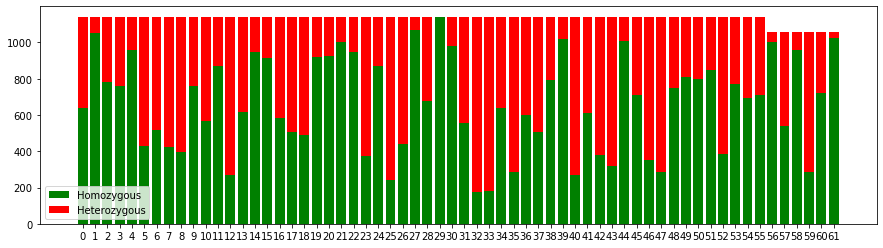

In [10]:
# total number of samples and heterogygosity
fig, ax = plt.subplots(1,1, figsize=(15,4))

homs = dict()

for ampl in AMPLS:
    gt = allel.GenotypeArray(callset[ampl]['calldata/genotype'])
    # homozygous if alleles (2) are the same across all variants (0) in sample (1)
    is_hom = (gt[:,:,0] == gt[:,:,1]).all(axis=0)
    homs[ampl] = is_hom
    p1 = ax.bar(ampl, is_hom.sum(), color='g')
    p2 = ax.bar(ampl, (is_hom == False).sum(), bottom=is_hom.sum(), color='r')
    plt.legend((p1[0], p2[0]), ('Homozygous', 'Heterozygous'))

In [12]:
# average heterozygosity
np.mean([(h == False).sum() / h.shape[0] for h in homs.values()])

0.41496163054664925

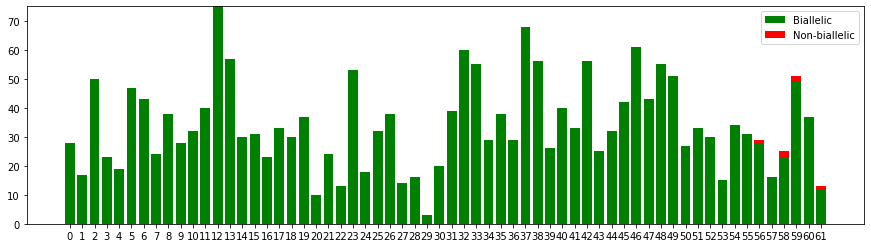

In [5]:
# biallelic vs non-biallelic variants
fig, ax = plt.subplots(1,1, figsize=(15,4))

for ampl in AMPLS:
    gt = allel.GenotypeArray(callset[ampl]['calldata/genotype'])
    ac = gt.count_alleles()
    biallelic = ac.is_biallelic()
    p1 = ax.bar(ampl, biallelic.sum(), color='g')
    p2 = ax.bar(ampl, (biallelic == False).sum(), bottom=biallelic.sum(), color='r')
    plt.legend((p1[0], p2[0]), ('Biallelic', 'Non-biallelic'))
# non-biallelic most likely result from samples missing from X

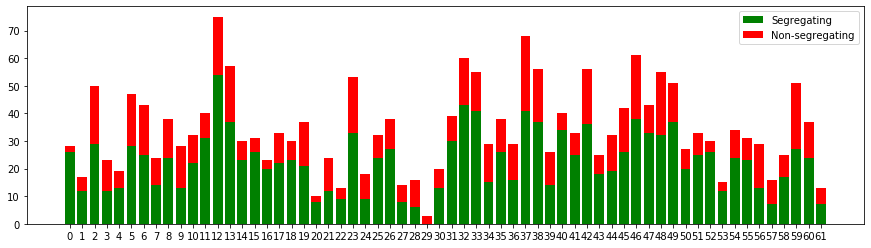

In [6]:
# get segregating vs non-segregaing variants
fig, ax = plt.subplots(1,1, figsize=(15,4))

for ampl in AMPLS:
    gt = allel.GenotypeArray(callset[ampl]['calldata/genotype'])
    ac = gt.count_alleles()
    # segregating - biallelic & minor allele count over one
    segregating = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    p1 = ax.bar(ampl, segregating.sum(), color='g')
    p2 = ax.bar(ampl, (segregating == False).sum(), bottom=segregating.sum(), color='r')
    plt.legend((p1[0], p2[0]), ('Segregating', 'Non-segregating'))
    

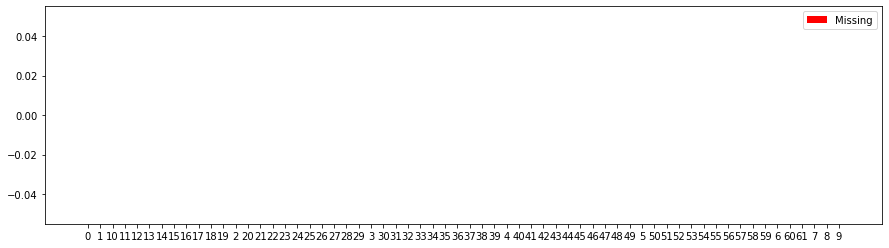

In [7]:
# missing genotypes
# all-missing genotype samples on X currently excluded
fig, ax = plt.subplots(1,1, figsize=(15,4))

for ampl in callset:
    gt = allel.GenotypeArray(callset[ampl]['calldata/genotype'])
    # missing - non-biallelic calls exist
    missing = ((gt.flatten() != 0) & (gt.flatten() != 1)).sum()
    p = ax.bar(ampl, missing, color='r')
    plt.legend(['Missing'])